In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg
# ! wget <uri> -P /path/to/folder

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-mrwvbnhb
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-mrwvbnhb
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=3f267f683e5ce9140044d35869389ad21d64e3e51a5e30fcf3991a8b32af480c
  Stored in directory: /tmp/pip-ephem-wheel-cache-b0bvylzu/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2023-07-24 05:14:36--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.c

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-4cx2prf9
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-4cx2prf9
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.7 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369501 sha256=1e92519969b6d48de31bcf49de9528157cee9ef4336e203d6a14b32613a71ccb
  Stored in directory: /tmp/pip-ephem-wheel-cache-rr4jp5lf/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import shutil
import torch
import clip
from PIL import Image
from itertools import islice
import os
import shutil

In [ ]:
def draw_bounding_box(image, bbox, color=(0, 255, 0), thickness=1):
    x, y, w, h = bbox
    cv2.rectangle(image, (x, y), (x + w, y + h), color, thickness)

In [ ]:
#Model loading and setting
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
def get_model():
      model, preprocess = clip.load("ViT-B/32", device=device)
      return model, preprocess
def get_prediction(frame_path, list_of_labels, how_many_predictions, model, preprocess) -> list:
    Highest3Predictions = []
    try:
        text = clip.tokenize(list_of_labels).to(device)
        image = preprocess(Image.open(frame_path)).unsqueeze(0).to(device)
        with torch.no_grad():
            logits_per_image, logits_per_text = model(image, text)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()
            probs = probs.tolist()[0]
        vv = {}
        for i, j in enumerate(probs):
            vv[list_of_labels[i]] = j
        maxx = {k: v for k, v in sorted(vv.items(), key=lambda item: item[1], reverse=True)}
        Highest3Predictions = list(islice(maxx.items(), how_many_predictions))
        print(f"{frame_path} : {Highest3Predictions}")
    except:
        pass

    return Highest3Predictions

In [ ]:
def is_height_five_times_width(bbox):
    x, y, width, height = bbox
    return height >= 4 * width
def is_width_five_times_height(bbox):
    x, y, width, height = bbox
    return width >= 4 * height

In [ ]:
model, preprocess = get_model()


100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 68.1MiB/s]


In [ ]:
how_many_predictions = 3

In [ ]:
list_of_labels = ["a photo of gun", "a photo of syringe", "a photo of smoking cigarette",  "a photo of sword", "a photo of knife",
                  "a photo of cocaine packet", "a photo of war artillery", "a photo of alcohol bottle",
                  "a photo of alcohol glass", "a photo of smoking marijuana joint", "a photo of prescription tablet",
                  "a photo of prescription bottle", "a photo of hard drugs tablet", "a photo of breast", "a photo of genitals",
                  "a photo of bare chest", "a photo of bare ass", "a photo of sex toy", "a photo of blood",
                  "a photo of blur object", "a photo of black screen", "a photo of body part", "a photo of face",
                  "a photo of neutral object",
                  "a photo of unidentified object", "a photo of "]

(720, 1280, 3)


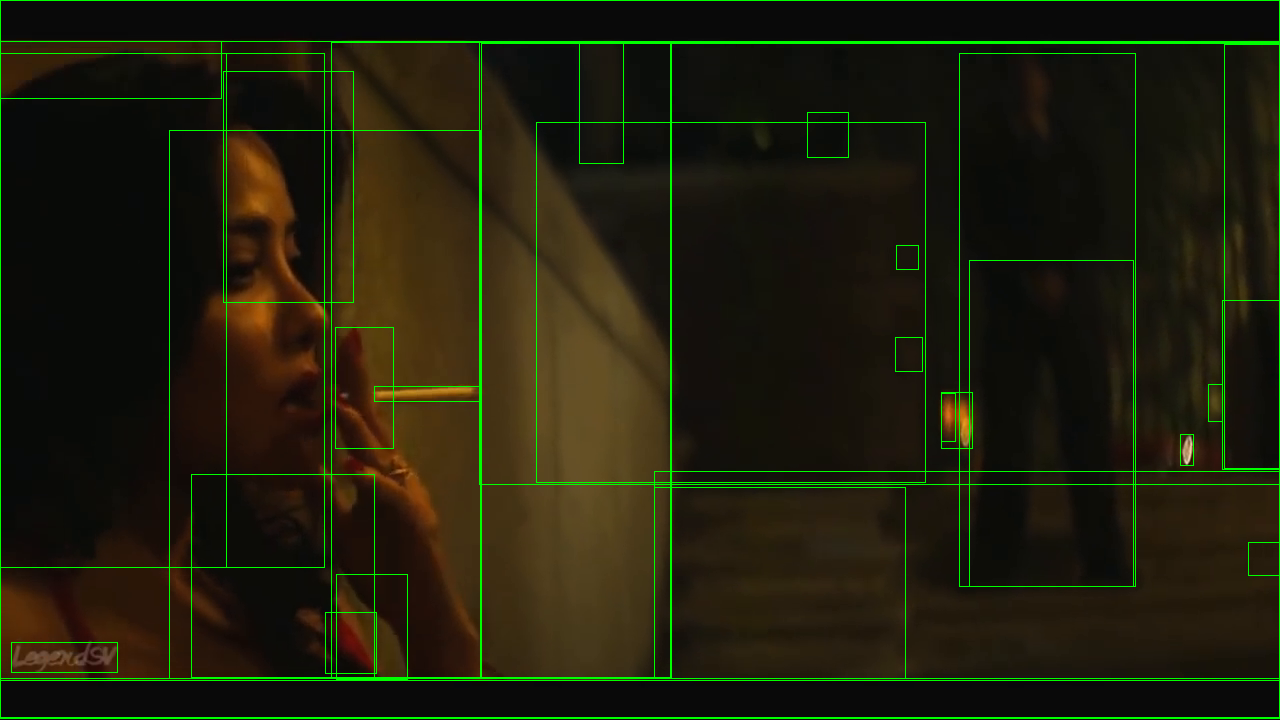

croppedBoxes/0.jpg : [('a photo of smoking cigarette', 0.8818359375), ('a photo of smoking marijuana joint', 0.09295654296875), ('a photo of syringe', 0.00838470458984375)]


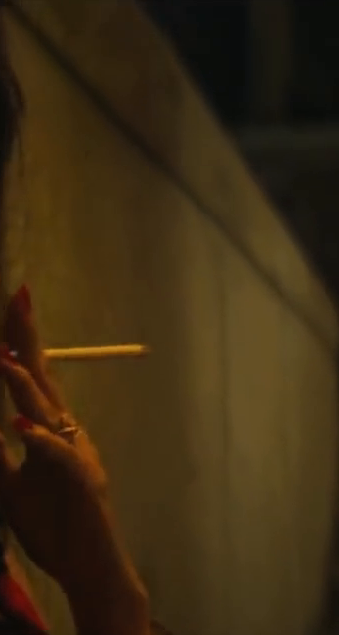

________________
croppedBoxes/3.jpg : [('a photo of black screen', 0.145263671875), ('a photo of sword', 0.1014404296875), ('a photo of blood', 0.08953857421875)]


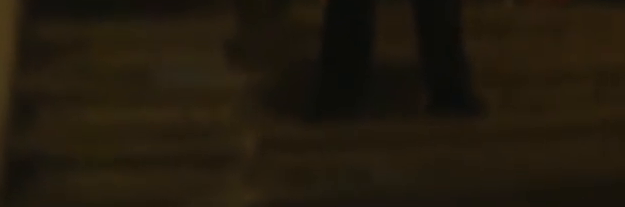

________________
croppedBoxes/4.jpg : [('a photo of black screen', 0.1629638671875), ('a photo of unidentified object', 0.1629638671875), ('a photo of blur object', 0.12890625)]


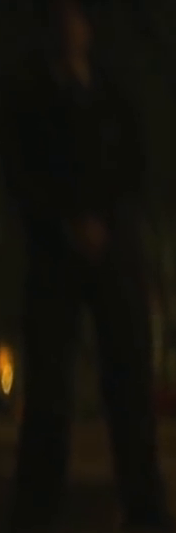

________________
croppedBoxes/5.jpg : [('a photo of face', 0.1370849609375), ('a photo of gun', 0.12286376953125), ('a photo of bare ass', 0.1209716796875)]


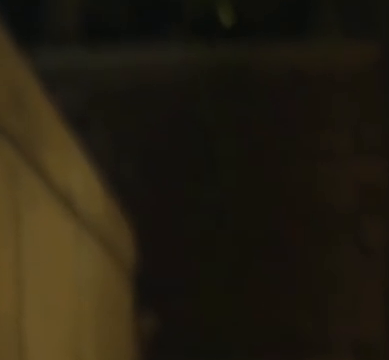

________________
croppedBoxes/6.jpg : [('a photo of smoking cigarette', 0.98291015625), ('a photo of smoking marijuana joint', 0.011993408203125), ('a photo of gun', 0.00164794921875)]


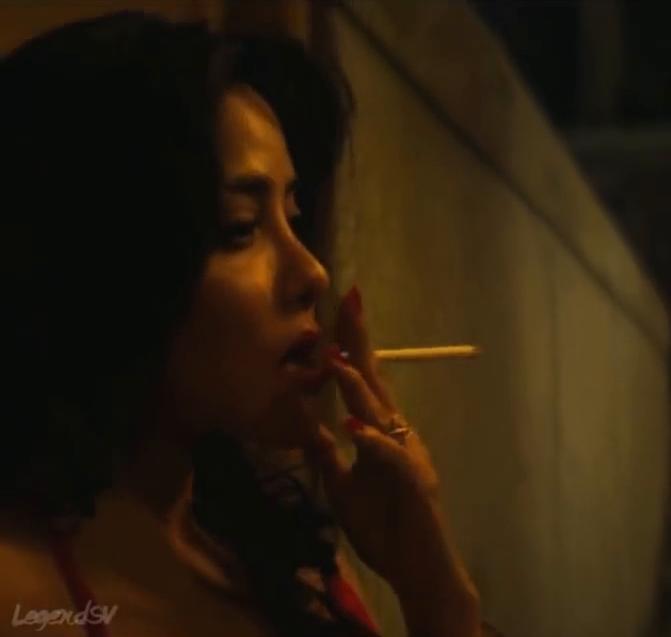

________________
croppedBoxes/8.jpg : [('a photo of bare ass', 0.136474609375), ('a photo of bare chest', 0.130126953125), ('a photo of alcohol bottle', 0.12420654296875)]


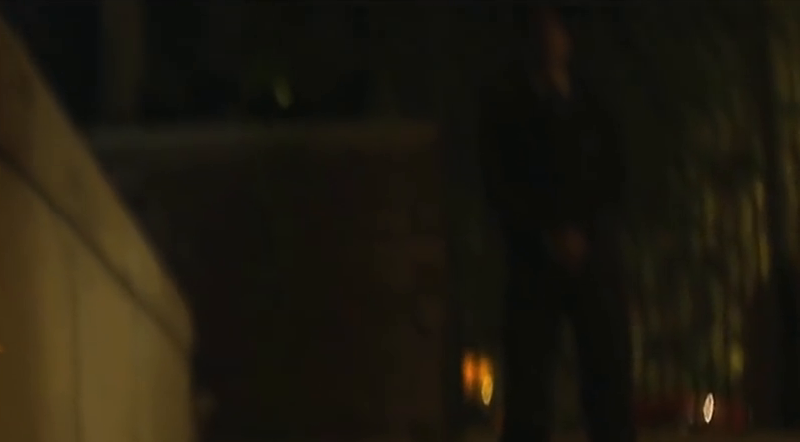

________________
croppedBoxes/9.jpg : [('a photo of face', 0.35888671875), ('a photo of gun', 0.09808349609375), ('a photo of blood', 0.081298828125)]


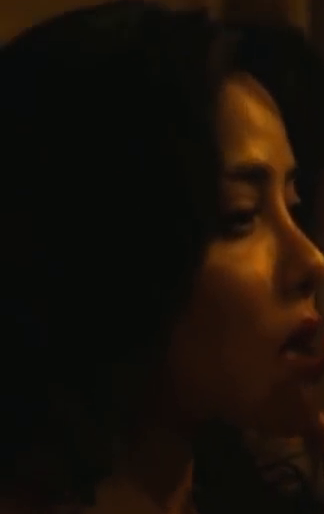

________________
croppedBoxes/10.jpg : [('a photo of smoking cigarette', 0.09368896484375), ('a photo of bare chest', 0.09222412109375), ('a photo of face', 0.08526611328125)]


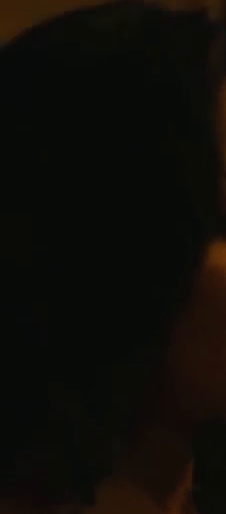

________________
croppedBoxes/14.jpg : [('a photo of genitals', 0.17822265625), ('a photo of blood', 0.11505126953125), ('a photo of unidentified object', 0.11505126953125)]


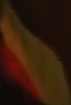

________________
croppedBoxes/15.jpg : [('a photo of unidentified object', 0.30419921875), ('a photo of black screen', 0.285888671875), ('a photo of genitals', 0.079345703125)]


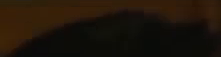

________________
croppedBoxes/16.jpg : [('a photo of smoking cigarette', 0.91845703125), ('a photo of smoking marijuana joint', 0.05780029296875), ('a photo of gun', 0.0059967041015625)]


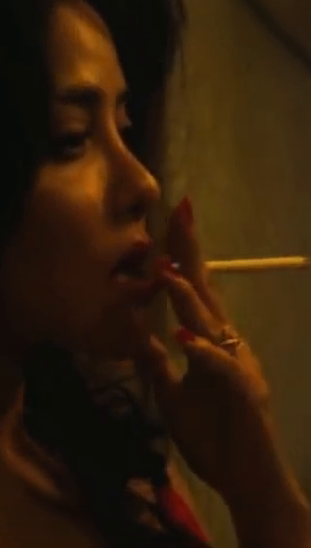

________________
croppedBoxes/17.jpg : [('a photo of bare ass', 0.5546875), ('a photo of gun', 0.10260009765625), ('a photo of sword', 0.0484619140625)]


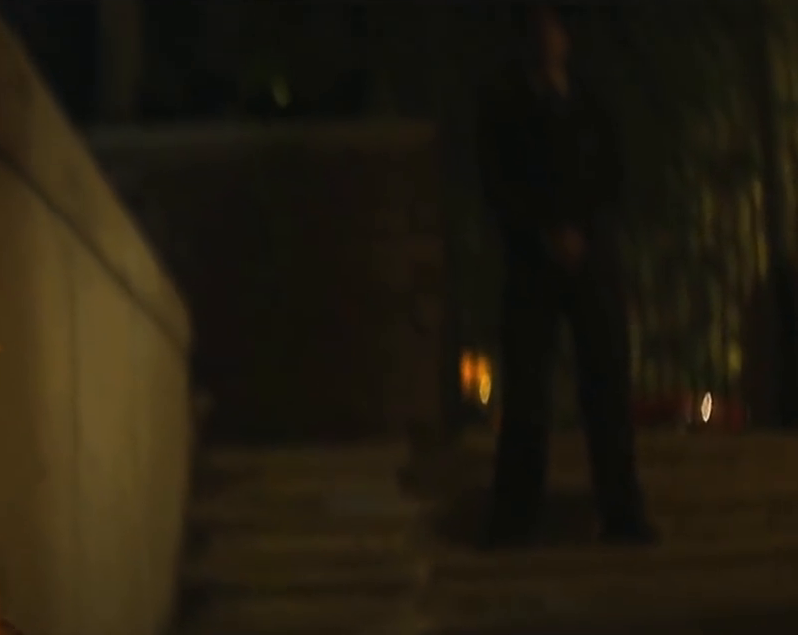

________________
croppedBoxes/18.jpg : [('a photo of blur object', 0.290283203125), ('a photo of unidentified object', 0.0745849609375), ('a photo of alcohol bottle', 0.055419921875)]


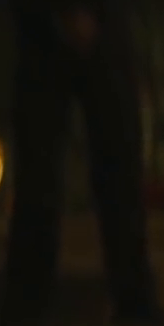

________________
croppedBoxes/22.jpg : [('a photo of face', 0.71435546875), ('a photo of genitals', 0.06243896484375), ('a photo of unidentified object', 0.044281005859375)]


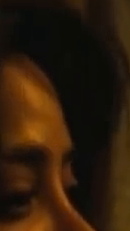

________________
croppedBoxes/24.jpg : [('a photo of black screen', 0.183349609375), ('a photo of knife', 0.11468505859375), ('a photo of sword', 0.1060791015625)]


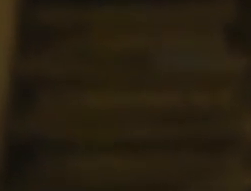

________________
croppedBoxes/25.jpg : [('a photo of unidentified object', 0.256103515625), ('a photo of black screen', 0.233154296875), ('a photo of genitals', 0.08056640625)]


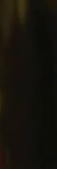

________________
croppedBoxes/27.jpg : [('a photo of unidentified object', 0.271728515625), ('a photo of genitals', 0.089599609375), ('a photo of blur object', 0.08154296875)]


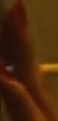

________________
croppedBoxes/28.jpg : [('a photo of face', 0.272705078125), ('a photo of gun', 0.17333984375), ('a photo of genitals', 0.10675048828125)]


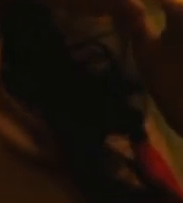

________________
croppedBoxes/32.jpg : [('a photo of genitals', 0.1807861328125), ('a photo of unidentified object', 0.1429443359375), ('a photo of blood', 0.109619140625)]


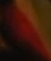

________________


In [ ]:
image = '/content/gdrive/MyDrive/testImages/F_1901.jpg'
image = cv2.imread(image)
print(image.shape)
masks = mask_generator.generate(image)
for m in masks:
  # Bounding box coordinates (x, y, width, height)
  bbox = tuple(m['bbox'])
  draw_bounding_box(image, bbox)
cv2_imshow(image)
image = '/content/gdrive/MyDrive/testImages/F_1901.jpg'
image = cv2.imread(image)
os.makedirs("croppedBoxes")
for aa, m in enumerate(masks):
  bbox = tuple(m['bbox'])
  # x1, y1, x2, y2 = bbox
  x, y, width, height = bbox
  diff_width = abs(width - image.shape[1])
  diff_height = abs(height - image.shape[0])
  if diff_width >= 200:
    if height >= 50 and width >= 50:
      if not is_height_five_times_width(bbox):
        if not is_width_five_times_height(bbox):
          cropped_image = image[y:y+height, x:x+width]
          # cropped_image = image[y1:y2, x1:x2]
          cv2.imwrite("croppedBoxes/" + str(aa) + ".jpg", cropped_image)
          Highest3Predictions = get_prediction("croppedBoxes/" + str(aa) + ".jpg", list_of_labels, how_many_predictions, model, preprocess)
          cv2_imshow(cropped_image)
          print("________________")
shutil.rmtree("croppedBoxes")

In [ ]:
image = '/content/gdrive/MyDrive/testImages/F_170.jpg'
image = cv2.imread(image)
os.makedirs("croppedBoxes")
for aa, m in enumerate(masks):
  bbox = tuple(m['bbox'])
  # x1, y1, x2, y2 = bbox
  x, y, width, height = bbox
  diff_width = abs(width - image.shape[1])
  diff_height = abs(height - image.shape[0])
  if diff_width >= 200:
    if height >= 50 and width >= 50:
      if not is_height_five_times_width(bbox):
        if not is_width_five_times_height(bbox):
          cropped_image = image[y:y+height, x:x+width]
          # cropped_image = image[y1:y2, x1:x2]
          try:
            cv2.imwrite("croppedBoxes/" + str(aa) + ".jpg", cropped_image)
            Highest3Predictions = get_prediction("croppedBoxes/" + str(aa) + ".jpg", list_of_labels, how_many_predictions, model, preprocess)
            cv2_imshow(cropped_image)
          except:
            pass
          print("________________")
shutil.rmtree("croppedBoxes")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
image = '/content/gdrive/MyDrive/testImages/F_114.jpg'
image = cv2.imread(image)
os.makedirs("croppedBoxes")
for aa, m in enumerate(masks):
  bbox = tuple(m['bbox'])
  # x1, y1, x2, y2 = bbox
  x, y, width, height = bbox
  diff_width = abs(width - image.shape[1])
  diff_height = abs(height - image.shape[0])
  if diff_width >= 200:
    if height >= 50 and width >= 50:
      if not is_height_five_times_width(bbox):
        if not is_width_five_times_height(bbox):
          cropped_image = image[y:y+height, x:x+width]
          # cropped_image = image[y1:y2, x1:x2]
          try:
            cv2.imwrite("croppedBoxes/" + str(aa) + ".jpg", cropped_image)
            Highest3Predictions = get_prediction("croppedBoxes/" + str(aa) + ".jpg", list_of_labels, how_many_predictions, model, preprocess)
            cv2_imshow(cropped_image)
          except:
            pass
          print("________________")
shutil.rmtree("croppedBoxes")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
image = '/content/gdrive/MyDrive/testImages/F_27.jpg'
image = cv2.imread(image)
os.makedirs("croppedBoxes")
for aa, m in enumerate(masks):
  bbox = tuple(m['bbox'])
  # x1, y1, x2, y2 = bbox
  x, y, width, height = bbox
  diff_width = abs(width - image.shape[1])
  diff_height = abs(height - image.shape[0])
  if diff_width >= 200:
    if height >= 50 and width >= 50:
      if not is_height_five_times_width(bbox):
        if not is_width_five_times_height(bbox):
          cropped_image = image[y:y+height, x:x+width]
          # cropped_image = image[y1:y2, x1:x2]
          try:
            cv2.imwrite("croppedBoxes/" + str(aa) + ".jpg", cropped_image)
            Highest3Predictions = get_prediction("croppedBoxes/" + str(aa) + ".jpg", list_of_labels, how_many_predictions, model, preprocess)
            cv2_imshow(cropped_image)
          except:
            pass
          print("________________")
shutil.rmtree("croppedBoxes")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
image = '/content/gdrive/MyDrive/testImages/F_2385.jpg'
image = cv2.imread(image)
os.makedirs("croppedBoxes")
for aa, m in enumerate(masks):
  bbox = tuple(m['bbox'])
  # x1, y1, x2, y2 = bbox
  x, y, width, height = bbox
  diff_width = abs(width - image.shape[1])
  diff_height = abs(height - image.shape[0])
  if diff_width >= 200:
    if height >= 50 and width >= 50:
      if not is_height_five_times_width(bbox):
        if not is_width_five_times_height(bbox):
          cropped_image = image[y:y+height, x:x+width]
          # cropped_image = image[y1:y2, x1:x2]
          try:
            cv2.imwrite("croppedBoxes/" + str(aa) + ".jpg", cropped_image)
            Highest3Predictions = get_prediction("croppedBoxes/" + str(aa) + ".jpg", list_of_labels, how_many_predictions, model, preprocess)
            cv2_imshow(cropped_image)
          except:
            pass
          print("________________")
shutil.rmtree("croppedBoxes")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
rm -R croppedBoxes